# 2. Train Improved UNet 3D (v3 - Augmentation + Scheduler)

This notebook improves upon v2 by adding:
- **Data Augmentation**: Random rotation, flip, and noise.
- **Learning Rate Scheduler**: Reduce LR on plateau.
- **Early Stopping**: Stop training if validation loss doesn't improve.
- **Model Checkpointing**: Save the best model based on validation loss.
- **Extended Training**: 50 epochs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import sys
import scipy.ndimage as ndimage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class LIDCPatchDataset(Dataset):
    def __init__(self, data_dir, transform=None, augment=False):
        all_files = sorted(glob.glob(str(Path(data_dir) / "*.npz")))
        self.files = []
        for f in all_files:
            data = np.load(f, allow_pickle=True)
            if 'mask' in data and np.sum(data['mask']) > 0:
                self.files.append(f)
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        data = np.load(path)
        image = data['image'].astype(np.float32)
        mask = data['mask'].astype(np.float32)
        label = np.array([data['label']], dtype=np.float32)

        # Normalize
        image = (image - (-1000)) / (400 - (-1000))
        image = np.clip(image, 0, 1)

        if self.augment:
            # Random Rotate
            angle = np.random.uniform(-15, 15)
            image = ndimage.rotate(image, angle, axes=(1, 2), reshape=False, order=1)
            mask = ndimage.rotate(mask, angle, axes=(1, 2), reshape=False, order=0)
            
            # Random Flip
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=1)
                mask = np.flip(mask, axis=1)
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=2)
                mask = np.flip(mask, axis=2)
                
            # Random Noise
            if np.random.rand() > 0.5:
                noise = np.random.normal(0, 0.005, image.shape)
                image = image + noise
            
            image = np.clip(image, 0, 1)

        # Copy to avoid negative strides and cast to float32
        image = np.expand_dims(image.copy(), axis=0).astype(np.float32)
        mask = np.expand_dims(mask.copy(), axis=0).astype(np.float32)

        return torch.tensor(image), torch.tensor(mask), torch.tensor(label)

## Visualizing Augmentation

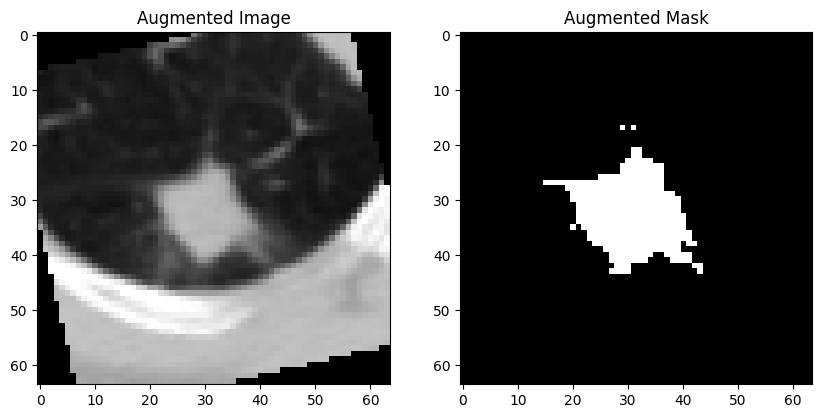

In [3]:
# Test Augmentation
dataset = LIDCPatchDataset("../data/lidc_patches", augment=True)
img, msk, lbl = dataset[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0, 32], cmap='gray')
plt.title('Augmented Image')
plt.subplot(1, 2, 2)
plt.imshow(msk[0, 32], cmap='gray')
plt.title('Augmented Mask')
plt.show()

In [4]:
# Model Definition (Same as before)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class LightweightUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.inc = DoubleConv(in_channels, 16)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(16, 32))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        self.up1 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)
        self.up3 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.conv3 = DoubleConv(32, 16)
        self.outc = nn.Conv3d(16, out_channels, 1)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        mask = torch.sigmoid(self.outc(u3))
        risk = torch.sigmoid(self.classifier(x4))
        return mask, risk

model = LightweightUNet3D().to(device)

In [5]:
# Loss & Data Loading
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

DATA_DIR = Path("../data/lidc_patches")
# Note: ONLY augment training data
full_dataset_train = LIDCPatchDataset(DATA_DIR, augment=True)
full_dataset_val = LIDCPatchDataset(DATA_DIR, augment=False)

# Split indices manually to keep train/val consistent but apply augment only to train
n_total = len(full_dataset_train)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
indices =  torch.randperm(n_total).tolist()
train_indices, val_indices = indices[:n_train], indices[n_train:]

train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset_val, val_indices)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Class Weight
all_labels = []
for idx in train_indices:
    f = full_dataset_train.files[idx]
    d = np.load(f)
    all_labels.append(d['label'])
all_labels = np.array(all_labels)
pos_sum = sum(all_labels)
neg_sum = len(all_labels) - pos_sum
pos_weight = torch.tensor([neg_sum / max(pos_sum, 1)]).to(device)
print(f"Pos Weight: {pos_weight.item():.2f}")

criterion_seg = DiceLoss()
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

Pos Weight: 2.05


In [6]:
def compute_dice_score(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    return (2. * intersection + 1) / (pred_bin.sum() + target.sum() + 1)

num_epochs = 50
patience = 15
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss, running_dice, running_acc = 0.0, 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for images, masks, labels in pbar:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        pred_masks, pred_risk = model(images)
        loss_seg = criterion_seg(pred_masks, masks)
        loss_cls = nn.BCELoss()(pred_risk, labels)
        loss = loss_seg + 0.5 * loss_cls
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_dice += compute_dice_score(pred_masks, masks).item()
        running_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Validate
    model.eval()
    val_loss, val_dice, val_acc = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            pred_masks, pred_risk = model(images)
            loss_seg = criterion_seg(pred_masks, masks)
            loss_cls = nn.BCELoss()(pred_risk, labels)
            loss = loss_seg + 0.5 * loss_cls
            val_loss += loss.item()
            val_dice += compute_dice_score(pred_masks, masks).item()
            val_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_dice'].append(running_dice / len(train_loader))
    history['val_dice'].append(val_dice / len(val_loader))
    history['train_acc'].append(running_acc / len(train_loader))
    history['val_acc'].append(val_acc / len(val_loader))
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {history['val_dice'][-1]:.4f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "../models/unet3d_best.pth")
        print(f"Saved Best Model (Loss: {best_val_loss:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

Epoch 1/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.3008 | Val Loss: 1.2795 | Val Dice: 0.0047
Saved Best Model (Loss: 1.2795)


Epoch 2/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.2898 | Val Loss: 1.1787 | Val Dice: 0.0045
Saved Best Model (Loss: 1.1787)


Epoch 3/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.2707 | Val Loss: 1.2554 | Val Dice: 0.0069


Epoch 4/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1.2966 | Val Loss: 1.2559 | Val Dice: 0.0064


Epoch 5/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1.2695 | Val Loss: 1.1970 | Val Dice: 0.0073


Epoch 6/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1.2499 | Val Loss: 1.3464 | Val Dice: 0.0065


Epoch 7/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1.2460 | Val Loss: 1.1639 | Val Dice: 0.0071
Saved Best Model (Loss: 1.1639)


Epoch 8/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1.2876 | Val Loss: 1.1229 | Val Dice: 0.0149
Saved Best Model (Loss: 1.1229)


Epoch 9/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1.2527 | Val Loss: 1.3334 | Val Dice: 0.0277


Epoch 10/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.2569 | Val Loss: 1.4119 | Val Dice: 0.0159


Epoch 11/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 1.2166 | Val Loss: 1.3990 | Val Dice: 0.1279


Epoch 12/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 1.2244 | Val Loss: 1.2970 | Val Dice: 0.0241


Epoch 13/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 1.2223 | Val Loss: 1.2780 | Val Dice: 0.0358


Epoch 14/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 1.1962 | Val Loss: 1.1542 | Val Dice: 0.0373


Epoch 15/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 1.2016 | Val Loss: 1.2310 | Val Dice: 0.0657


Epoch 16/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 1.1849 | Val Loss: 1.1566 | Val Dice: 0.3247


Epoch 17/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 1.1463 | Val Loss: 1.1535 | Val Dice: 0.2426


Epoch 18/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 1.1412 | Val Loss: 1.2169 | Val Dice: 0.1512


Epoch 19/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 1.1257 | Val Loss: 1.1609 | Val Dice: 0.1229


Epoch 20/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 1.1071 | Val Loss: 1.1579 | Val Dice: 0.0838


Epoch 21/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 1.0791 | Val Loss: 1.1518 | Val Dice: 0.3656


Epoch 22/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 1.0656 | Val Loss: 1.1723 | Val Dice: 0.2084


Epoch 23/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 1.0117 | Val Loss: 1.1283 | Val Dice: 0.3224
Early stopping!


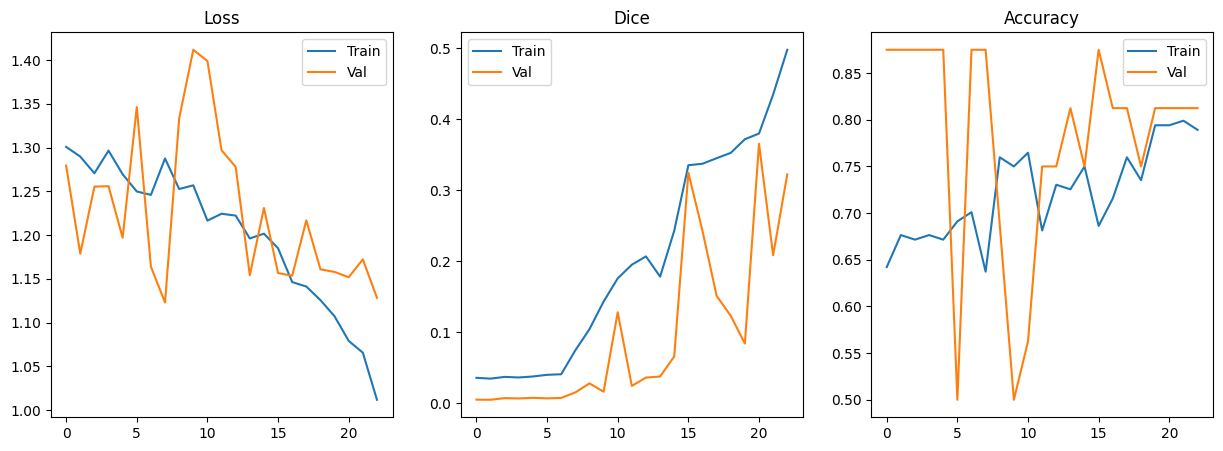

In [7]:
# Plot History
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='Train')
ax[0].plot(history['val_loss'], label='Val')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['train_dice'], label='Train')
ax[1].plot(history['val_dice'], label='Val')
ax[1].set_title('Dice')
ax[1].legend()

ax[2].plot(history['train_acc'], label='Train')
ax[2].plot(history['val_acc'], label='Val')
ax[2].set_title('Accuracy')
ax[2].legend()
plt.show()